In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split

import pickle
import pandas as pd
import preprocessor as p
import re
import numpy as np

import pickle
import matplotlib.pyplot as plt

In [3]:
dataset_location = 'Data3.csv'
data_set = pd.read_csv(dataset_location,header=None)
data_set = data_set.loc[pd.notnull(data_set[0])]
data_set.rename(columns={0: "text"},inplace=True)

In [4]:
my_punctuation = '!"#$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@â'

def remove_links(tweet):
    tweet = re.sub(r'http\S+', '', tweet) 
    tweet = re.sub(r'bit.ly/\S+', '', tweet) 
    tweet = tweet.strip('[link]') 
    return tweet
def remove_users(tweet):
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    return tweet
def remove_punctuation(tweet):
    tweet = re.sub('['+my_punctuation + ']+', ' ', tweet)  
    return tweet
def remove_number(tweet):
    tweet = re.sub('([0-9]+)', '', tweet) 
    return tweet
def remove_hashtag(tweet):
    tweet = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) 
    return tweet
def remove_emoji(tweet):  
    tweet = re.sub(r"\\[a-z][a-z]?[0-9]+","",tweet)
    return tweet

In [5]:
def preprocess(tweet):
    tweet = remove_links(tweet)
    tweet = remove_number(tweet)
    tweet = remove_users(tweet)
    tweet = remove_emoji(tweet)
#     tweet = remove_hashtag(tweet)
    tweet = remove_punctuation(tweet)     
    tweet = tweet.lower().strip()
    tweet = " ".join(tweet.split())
#     temp = [word for word in tweet.split() if len(word)<14 and len(word)>3]
#     tweet= " ".join(temp)
    return tweet   

In [6]:
X=[]
for tweet in data_set["text"]:
    X.append(preprocess(tweet))
    
print(len(X))

250520


In [7]:
X_train,X_test = train_test_split(X, test_size=0.3, random_state=42)

In [14]:
n_features = 200000
n_components = 6
n_top_words = 10

thresh_max = 0.9
thresh_min = 1

In [16]:
tfidf_vect = TfidfVectorizer(analyzer='word',max_df=thresh_max, min_df=thresh_min, max_features=n_features, stop_words='english')
tfidf_vect.fit(X) # learn vocabulary and idf from training set
print(len(tfidf_vect.get_feature_names()))

tfidf_train =  tfidf_vect.transform(X_train)
tfidf_test =  tfidf_vect.transform(X_test)
tfidf =  tfidf_vect.transform(X)

In [33]:
with open('tfidf.pkl','wb') as f:
    pickle.dump(tfidf_vect,f)

In [34]:
num_topics= range(10,50,5)
models=[]
log_likeli=[]
log_perp=[]
for num in num_topics:
    print(num)
    # LDA
    # create Latent Dirichlet Allocation model and run it on our data with 50 iteration and selected topics number
    lda = LatentDirichletAllocation(n_components=num, max_iter=50)
    # fit the model on data
    ldaModel = lda.fit(tfidf_train)
    models.append(ldaModel)
    ll = lda.score(tfidf_test)
    lp = lda.perplexity(tfidf_test)
    log_likeli.append(ll)
    log_perp.append(lp)

10
15
20
25
30
35
40
45


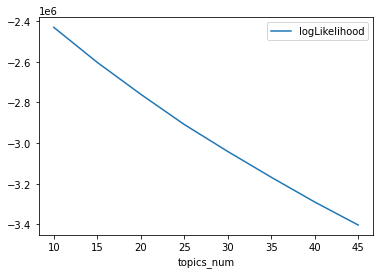

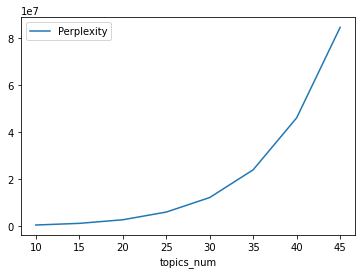

In [40]:
plot_data=pd.DataFrame(list(zip(num_topics,log_likeli,log_perp)),
            columns=['topics_num','logLikelihood','Perplexity'])    


# use the elbow method to determine the optimal k
plot_data.plot(x='topics_num',y='logLikelihood',kind = 'line')
plt.show()

# use the elbow method to determine the optimal k
plot_data.plot(x='topics_num',y='Perplexity',kind = 'line')
plt.show()

In [20]:
lda = LatentDirichletAllocation(n_components=15, max_iter=100,random_state=0)
# fit the model on data
ldaModel = lda.fit(tfidf)

In [12]:
with open('lda.pkl','wb') as f:
    pickle.dump(lda,f)

In [17]:
model =lda
vectorizer = tfidf_vect

feature_names = vectorizer.get_feature_names()

for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    print(top_features)

['trump', 'breaking', 'just', 'canden', 'cadens', 'antifa', 'look', 'beas', 'beai', 'video']
['sports', 'lsu', 'saints', 'new', 'orleans', 'game', 'news', 'pelicans', 'vs', 'nfl']
['police', 'black', 'baltimore', 'man', 'blacklivesmatter', 'shooting', 'shot', 'killed', 'woman', 'cops']
['stocks', 'workout', 'finance', 'stock', 'fitness', 'today', 'thanks', 'profile', 'new', 'day']
['nfl', 'anthem', 'trump', 'players', 'knee', 'player', 'national', 'breaking', 'football', 'video']
['trump', 'video', 'soundcloud', 'korea', 'breaking', 'gt', 'north', 'playing', 'click', 'plays']
['people', 'don', 'weight', 'like', 'lose', 'just', 'love', 'black', 'need', 'know']
['politics', 'louisiana', 'news', 'mayor', 'trump', 'san', 'juan', 'john', 'edwards', 'tax']
['на', 'за', 'из', 'по', 'сша', 'chelsea', 'не', 'человек', 'россии', 'рф']
['der', 'die', 'berlin', 'und', 'für', 'auf', 'mit', 'ist', 'von', 'im']
['nowplaying', 'trump', 'dagrfm', 'kimmel', 'jimmy', 'fails', 'fires', 'schwer', 'video', 

In [24]:
def get_inference(model, vectorizer, topics, text, threshold):
    v_text = vectorizer.transform([preprocess(text)])
    score = model.transform(v_text)

    labels = set()
    for i in range(len(score[0])):
        if score[0][i] > threshold:
            labels.add(topics[i])

    if not labels:
        return 'None', -1, set()

    return topics[np.argmax(score)], score, labels

In [31]:
for text in data_set["text"][:100].tolist():
    topic, score, label = get_inference(lda, tfidf_vect, range(15), text, 0.5)
    if topic != 'None':
#         print(text)
#         print(np.max(score))
        print(str(label)+text)

{11}Donald Trump met Russian ambassador during election campaign https://t.co/oArd5BSGBK
{2}Russia deploys deadly 'SIZZLER' nuclear submarines as US conflict looms https://t.co/YIqseUIyHq https://t.co/gBabIzOmRh
{4}Player ratings: Can any Arsenal players hold their heads high after last night? https://t.co/HM1aFTcIxK https://t.co/z3FmbJkLUG
{2}The Replacement episode two review: increasingly chilling as the plot thickens https://t.co/U7AvuQufU8
{2}#GayPride #PrayForGay Someone tell LGBT that they are annoying to death
{2}Religion today is so easily rejected but it has been with us for 2000 years #PrayForGay #GayPride
{6}I'm angry but I still love you.
{3}Drop that Xbox, man!
{6}Single doesn't always mean lonely, and relationship doesn't always mean happy.
{6}Where's your will to be weird?
{6}How wonderful it is that nobody need wait a single moment before starting to improve the world.  – Anne Frank
{4}How Can You Still Call That A Skirt??
{6}Puncha yo buns, puncha yo buns!
{6}Sometime